# Movie Recommendation Engine



This notebook aims to built different movie recommendation engines that provides personalized movie recommendations to users with different techniques. In Machine Learning, the primary methods for building recommendation system are ***Content-based*** and ***Collaborative filtering***.

***Content-based Filter:*** suggest products or items similar to user's past preferences (less abilitiy to discover new genres and movies)



***Collaborative Filter:*** suggest products or items from choices of similar users

# Introduction

In this notebook, there are four datasets used:

The Movie Dataset contains information on 45,000 movies. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

The Credicts Dataset consists of Cast and Crew Information for all movies in the movie dataset. Available in the form of a stringified JSON Object.

The Keywords Dataset contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

The Ratings Dataset includes the ratings from users on 45,000 movies.

*source: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data


To built collaborative-filtering-based recommender, the library suprise is used. Suprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data, and provides simple implementation of different algorithms. 

*source: https://surpriselib.com/

The notebook can be divided into 3 parts:

In the first part, the movie meta data will be explored to get the overview of the movie data and gain the first insights through some visualisations.

In the second part, the content-based filter will be applied with the first three datasets to built the first simple recommender

In the third part, the collaborative filter will be applied to the movie dataset and the ratings dataset to built a more personalized movie recommender.


By analyzing the meta data, a weighted rating will be calculated and appended in the dataframe. Due to the large amount of the data and the lack of the resources, only the movies with minimal weighted ratings will be used to built movie recommendation engine.

In [1]:
%matplotlib inline

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from scipy.sparse import hstack
import os

from ast import literal_eval

from surprise import Reader, Dataset, SVD

from surprise.model_selection import cross_validate

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import matplotlib.ticker as ticker

import squarify



pd.options.display.max_columns=None

#pd.set_option('display.max_colwidth', None)

plt.figure(figsize=(12, 8))

import warnings; warnings.simplefilter('ignore')

<Figure size 1200x800 with 0 Axes>

# Load Data



analyse the movie meta dataset

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

movies = pd.read_csv("/kaggle/input/the-movies-dataset/movies_metadata.csv")
credits = pd.read_csv("/kaggle/input/the-movies-dataset/credits.csv")
keywords = pd.read_csv("/kaggle/input/the-movies-dataset/keywords.csv")
ratings = pd.read_csv("/kaggle/input/the-movies-dataset/ratings.csv")

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv


In [3]:
#movies = pd.read_csv('data/movies.csv')
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [4]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [5]:
movies.shape

(45466, 24)

identify null values

In [6]:
movies.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

identify duplicate movies

In [7]:
# Count the number of duplicated 'id' values

duplicated_ids = movies['id'].duplicated().sum()

print(f"Number of duplicate ids: {duplicated_ids}")

Number of duplicate ids: 30


In [8]:
# Drop duplicates, keeping only the first occurrence of each 'id'

movies = movies.drop_duplicates(subset='id', keep='first')

movies.reset_index(drop=True, inplace=True)

movies.shape

(45436, 24)

**Observation**



* There are large amount of null values

* Some features are in dictionary type

* There are 30 duplicated rows 

# Transform

The columns genres, production_companies, production_countries and spoken_languages are stored as string representations of lists of dictionaries, which are difficult to analyse. Therefore, in the following step, these will be transformed to actual Python lists and replaces missing values in the columns with empty lists.

In [9]:
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies['production_companies']= movies['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies['production_countries'] = movies['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

movies['spoken_languages'] = movies['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Extract release year of each movie to use as feature for filtering or time-based recommendations

In [10]:
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [11]:
movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995


# Feature Engineering

Weighted ranking is often used in movie ranking systems to rank movies based on both their ***average rating*** and the ***number of votes*** they have received. The purpose is to give a fairer rank to movies by considering both the rating quality (R) and the popularity (v) of the movie, preventing less-voted but highly-rated movies from unfairly dominating the list.



The Formula of **Weighted Rank(WR)**:



$$

WR = \left( \frac{v}{v+m} \right) \times R + \left( \frac{m}{v+m} \right) \times C

$$



Where:



- \( R \) = average rating of the movie

- \( v \) = number of votes for the movie  

- \( m \) = minimum votes required to be listed in the Top 250  

- \( C \) = the mean vote across the whole dataset

In [12]:
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')

vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')

In [13]:
C = vote_averages.mean()

m = vote_counts.quantile(0.90)  # only movies in the top 10% (with the highest number of votes) will be considered.

print('The Mean value of the voting averages:',C)

print('The minimum vote count for a movie to consider: ',m)

The Mean value of the voting averages: 5.24503631961259
The minimum vote count for a movie to consider:  160.0


create a new dataframe containing only the movies that meet the following conditions:



* The movie’s vote_count must be greater than or equal to m (the 90th percentile of votes).

* The movie’s vote_count and vote_average must be non-null (i.e., they exist).

In [14]:
df = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())][['id','title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]

df.head()

,id,title,year,vote_count,vote_average,popularity,genres
0,862,Toy Story,1995,5415.0,7.7,21.946943,"[Animation, Comedy, Family]"
1,8844,Jumanji,1995,2413.0,6.9,17.015539,"[Adventure, Fantasy, Family]"
4,11862,Father of the Bride Part II,1995,173.0,5.7,8.387519,[Comedy]
5,949,Heat,1995,1886.0,7.7,17.924927,"[Action, Crime, Drama, Thriller]"
8,9091,Sudden Death,1995,174.0,5.5,5.23158,"[Action, Adventure, Thriller]"


In [15]:
df['vote_count'] = df['vote_count'].astype('int')

df['vote_average'] = df['vote_average'].astype('int')

print(df.shape)

(4551, 7)


**Observation**



* The average ratings for a movie is 5.245 of 10

* A movie must have at least 160 votes will be considered for qualify

* Only 4551 movies will be on chart

create a new column to store the weighted ratings

In [16]:
df['w_ratings'] = (df['vote_count'] / (df['vote_count'] + m)) * df['vote_average'] + (m / (df['vote_count'] + m)) * C

df

,id,title,year,vote_count,vote_average,popularity,genres,w_ratings
0,862,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]",6.949633
1,8844,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]",5.953053
4,11862,Father of the Bride Part II,1995,173,5,8.387519,[Comedy],5.117735
5,949,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]",6.862759
8,9091,Sudden Death,1995,174,5,5.23158,"[Action, Adventure, Thriller]",5.117383
...,...,...,...,...,...,...,...,...
45145,339692,Shot Caller,2017,324,6,15.786854,"[Drama, Crime, Thriller]",5.750425
45148,375798,Brice 3,2016,160,4,7.276407,[Comedy],4.622518
45175,417870,Girls Trip,2017,393,7,37.964872,[Comedy],6.492235
45229,417320,Descendants 2,2017,171,7,15.842073,"[TV Movie, Family, Action, Comedy, Music, Adve...",6.151679


Analyse the new dataframe based on movie title

In [17]:
unique_titles_count = df['title'].nunique()

total_titles_count = df['title'].count()

print("\nUnique titles:", unique_titles_count)

print("Total titles:", total_titles_count)

print("Number of duplicate titles:", total_titles_count - unique_titles_count)


Unique titles: 4460
Total titles: 4551
Number of duplicate titles: 91


Explore the duplication in the dataframe

In [18]:
duplicates = df[df.duplicated(subset=['title'], keep=False)]



duplicate_titles_df = duplicates.sort_values('title') # create a new DataFrame containing all rows with duplicate titles

print("DataFrame containing duplicate titles:\n")

duplicate_titles_df

DataFrame containing duplicate titles:



,id,title,year,vote_count,vote_average,popularity,genres,w_ratings
1299,377,A Nightmare on Elm Street,1984,1212,7,13.694713,[Horror],6.795340
15179,23437,A Nightmare on Elm Street,2010,771,5,10.40191,"[Horror, Mystery, Thriller]",5.042112
14887,12155,Alice in Wonderland,2010,4773,6,17.285093,"[Family, Fantasy, Adventure]",5.975513
1003,12092,Alice in Wonderland,1951,1557,7,16.488937,"[Animation, Adventure, Family, Fantasy]",6.836462
25702,196867,Annie,2014,472,6,13.275529,"[Comedy, Drama, Family]",5.808870
...,...,...,...,...,...,...,...,...
4623,16307,The Wicker Man,1973,313,7,7.206941,"[Horror, Music, Mystery, Thriller]",6.406355
2799,861,Total Recall,1990,1745,7,12.954444,"[Action, Adventure, Science Fiction]",6.852601
19210,64635,Total Recall,2012,2540,5,16.42635,"[Action, Science Fiction, Adventure, Thriller]",5.014521
3372,17529,True Grit,1969,205,7,12.497833,[Western],6.230701


**Observation**



* There are 179 duplicate movies in the dataframe.

* The duplication due to different release year

# Visualisation

Since the column genres contains a list of name, it is necessary to transform it before applying visualisation

In [19]:
df_exploded = df.explode('genres')

df_exploded = df_exploded.rename(columns={'genres': 'genre'})

df_exploded

,id,title,year,vote_count,vote_average,popularity,genre,w_ratings
0,862,Toy Story,1995,5415,7,21.946943,Animation,6.949633
0,862,Toy Story,1995,5415,7,21.946943,Comedy,6.949633
0,862,Toy Story,1995,5415,7,21.946943,Family,6.949633
1,8844,Jumanji,1995,2413,6,17.015539,Adventure,5.953053
1,8844,Jumanji,1995,2413,6,17.015539,Fantasy,5.953053
...,...,...,...,...,...,...,...,...
45229,417320,Descendants 2,2017,171,7,15.842073,Action,6.151679
45229,417320,Descendants 2,2017,171,7,15.842073,Comedy,6.151679
45229,417320,Descendants 2,2017,171,7,15.842073,Music,6.151679
45229,417320,Descendants 2,2017,171,7,15.842073,Adventure,6.151679


The top 250 movies with highest weighted ratings

In [20]:
top250 = df_exploded.sort_values('w_ratings', ascending=False).drop_duplicates('title').head(250)

top250

,id,title,year,vote_count,vote_average,popularity,genre,w_ratings
10306,19404,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,Drama,8.268217
15474,27205,Inception,2010,14075,8,29.108149,Adventure,7.969034
12477,155,The Dark Knight,2008,12269,8,123.167259,Action,7.964535
22865,157336,Interstellar,2014,11187,8,32.213481,Adventure,7.961153
2842,550,Fight Club,1999,9678,8,63.869599,Drama,7.955195
...,...,...,...,...,...,...,...,...
11004,350,The Devil Wears Prada,2006,3198,7,13.102384,Drama,6.916381
21592,146233,Prisoners,2013,3183,7,11.96262,Drama,6.916005
13183,13223,Gran Torino,2008,3181,7,14.794228,Drama,6.915955
21264,138843,The Conjuring,2013,3169,7,14.90169,Horror,6.915652


The top 20 movies with highest weighted ratings

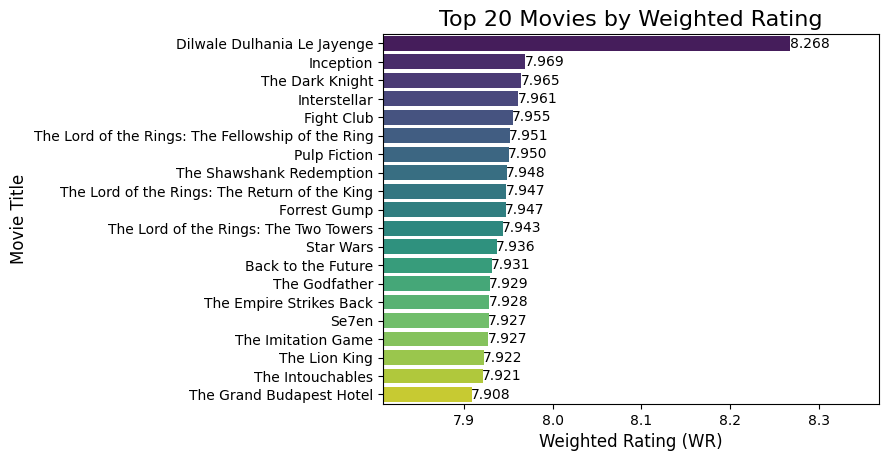

In [21]:
top20 = df_exploded.sort_values('w_ratings', ascending=False).drop_duplicates('title').head(20)

sns.barplot(x='w_ratings', y='title', data=top20, palette='viridis')

plt.title('Top 20 Movies by Weighted Rating',fontsize=16)

plt.xlabel('Weighted Rating (WR)', fontsize=12)

plt.ylabel('Movie Title', fontsize=12)



# Get the minimum and maximum values in 'w_ratings' to set appropriate xlim

min_wr = top20['w_ratings'].min()

max_wr = top20['w_ratings'].max()



# Set xlim based on the actual data, but zoom in slightly to highlight differences

plt.xlim(min_wr - 0.1, max_wr + 0.1)



# Add the exact WR value on the bars for higher precision

for index, value in enumerate(top20['w_ratings']):

    plt.text(value - 0.001, index, f'{value:.3f}', color='black', va="center")



# Format the x-axis ticks to show only one decimal place

plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))



plt.show()

The popularity (frequency) of genres in the top 250 movies

In [22]:
# Count the number of movies per genre in the top 250 dataframe

genre_count = top250['genre'].value_counts().reset_index()

genre_count.columns = ['genre', 'count']  # Rename columns for clarity

genre_count

,genre,count
0,Drama,60
1,Adventure,30
2,Thriller,25
3,Action,20
4,Science Fiction,16
5,Family,16
6,Animation,14
7,Comedy,14
8,Romance,13
9,Fantasy,12


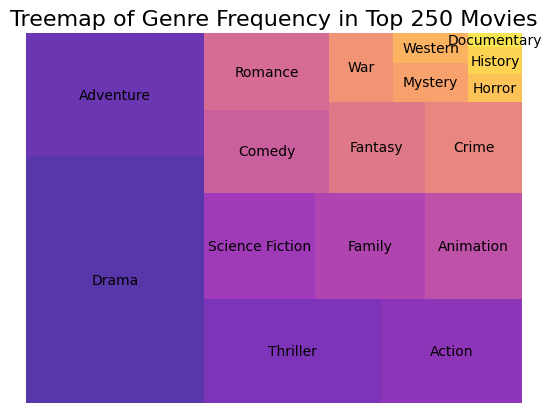

In [23]:
# Normalize the genre counts for better visualization

sizes = genre_count['count']



# Create a treemap

squarify.plot(sizes=sizes, label=genre_count['genre'], alpha=0.8, color=sns.color_palette('plasma', len(genre_count)))

plt.title('Treemap of Genre Frequency in Top 250 Movies', fontsize=16)

plt.axis('off')

plt.show()

The popularity of genres in the top 20 movies

In [24]:
# Count the number of movies per genre in the top 20 DataFrame

genre_count2 = top20['genre'].value_counts().reset_index()

genre_count2.columns = ['genre', 'count']

genre_count2

,genre,count
0,Adventure,5
1,Drama,4
2,Comedy,3
3,Thriller,2
4,Crime,2
5,Action,1
6,Fantasy,1
7,Science Fiction,1
8,Animation,1


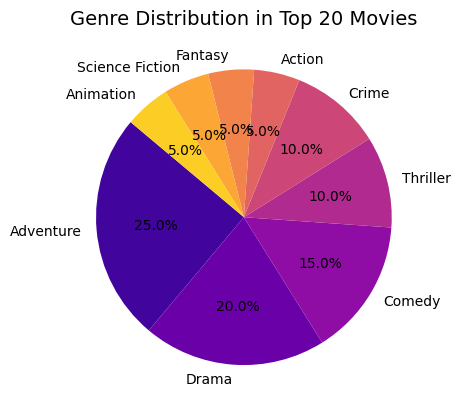

In [25]:
plt.pie(genre_count2['count'], labels=genre_count2['genre'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('plasma', len(genre_count2)))

plt.title('Genre Distribution in Top 20 Movies', fontsize=14)

plt.gca().set_aspect('equal')  # Equal aspect ratio to ensure the donut is circular

plt.show()

**Observation**



* Drama is the most popular genre in the top 250 movies is Drama, followed by Adventure, Thriller, Action and Science Fiction

* In the top 20 movies, the most popular genre is Adventure, followed by Drama and Comedy.

Find the top 20 movies for a genre

In [26]:
def get_top_movies_by_genre(genre, df):

    """

    Returns a DataFrame with the top 10 movies for a specific genre from the provided DataFrame.



    Parameters:

    genre (str): The genre for which to retrieve the top movies.

    df (DataFrame): The DataFrame containing the top movies.



    Returns:

    DataFrame: A filtered DataFrame with the top 10 movies for the given genre, including title, year, popularity, genre, and w_ratings.

    """

    # Filter the DataFrame for the specified genre

    genre_movies = df[df['genre'].str.contains(genre, case=False, na=False)]

    

    # Sort the filtered DataFrame by weighted ratings in descending order

    top_movies = genre_movies.sort_values(by='w_ratings', ascending=False).head(10)

    

    # Return the filtered DataFrame (title, year, popularity, genre, and w_ratings for better visualization)

    return top_movies[['title', 'year', 'popularity', 'w_ratings']].drop_duplicates('title')


In [27]:
get_top_movies_by_genre('Action', df_exploded)

,title,year,popularity,w_ratings
15474,Inception,2010,29.108149,7.969034
12477,The Dark Knight,2008,123.167259,7.964535
4862,The Lord of the Rings: The Fellowship of the Ring,2001,32.070725,7.951304
6999,The Lord of the Rings: The Return of the King,2003,29.324358,7.947437
5813,The Lord of the Rings: The Two Towers,2002,29.423537,7.943495
256,Star Wars,1977,42.149697,7.936467
1154,The Empire Strikes Back,1980,19.470959,7.928419
4134,Scarface,1983,11.299673,7.861255
9427,Oldboy,2003,10.616859,7.795929
1909,Seven Samurai,1954,15.01777,7.580994


# Content based  Recommender



In this part, a recommendation engine is built, which computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. For this purpose, the dataset credits and keywords are used additionally. 



The goal is to built a personalized recommendation engine according to the favorite cast and director.

In [28]:
#credits = pd.read_csv('data/credits.csv')

#keywords = pd.read_csv('data/keywords.csv')

In [29]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [30]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [31]:
credits.shape

(45476, 3)

In [32]:
keywords.shape

(46419, 2)

identify duplicates ids

In [33]:
# Drop duplicates, keeping only the first occurrence of each 'id'

credits = credits.drop_duplicates(subset='id', keep='first')

credits.reset_index(drop=True, inplace=True)

credits.shape

(45432, 3)

In [34]:
keywords = keywords.drop_duplicates(subset='id', keep='first')

keywords.reset_index(drop=True, inplace=True)

keywords.shape

(45432, 2)

In [35]:
keywords['id'] = keywords['id'].astype('int')

credits['id'] = credits['id'].astype('int')

df['id'] = df['id'].astype('int') 

merge the dataset

In [36]:
df2 = df.merge(credits, on='id')

df2 = df2.merge(keywords, on='id')

In [37]:
df2.head()

,id,title,year,vote_count,vote_average,popularity,genres,w_ratings,cast,crew,keywords
0,862,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]",6.949633,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]",5.953053,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,11862,Father of the Bride Part II,1995,173,5,8.387519,[Comedy],5.117735,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
3,949,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]",6.862759,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'id': 642, 'name': 'robbery'}, {'id': 703, '..."
4,9091,Sudden Death,1995,174,5,5.23158,"[Action, Adventure, Thriller]",5.117383,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...","[{'id': 949, 'name': 'terrorist'}, {'id': 1562..."


In [38]:
df2.shape

(4551, 11)

In [39]:
df2['cast'] = df2['cast'].apply(literal_eval)

df2['crew'] = df2['crew'].apply(literal_eval)

df2['keywords'] = df2['keywords'].apply(literal_eval)



# create new columns to store the size of cast and crew

df2['cast_size'] = df2['cast'].apply(lambda x: len(x))

df2['crew_size'] = df2['crew'].apply(lambda x: len(x))

In [40]:
# convert dictionaries to list

df2['cast'] = df2['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

df2['keywords'] = df2['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [41]:
df2.head()

,id,title,year,vote_count,vote_average,popularity,genres,w_ratings,cast,crew,keywords,cast_size,crew_size
0,862,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]",6.949633,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106
1,8844,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]",5.953053,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16
2,11862,Father of the Bride Part II,1995,173,5,8.387519,[Comedy],5.117735,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7
3,949,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]",6.862759,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[robbery, detective, bank, obsession, chase, s...",65,71
4,9091,Sudden Death,1995,174,5,5.23158,"[Action, Adventure, Thriller]",5.117383,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...","[terrorist, hostage, explosive, vice president]",6,9


For content-based Recommender, cast and crew would be important features. However, there isn't relevent to consider all cast and crew within a movie. Therefore, only the first four cast in the list and the director of movies will be considered.

first take a look how the crew column looks like

In [42]:
#df2['crew'].iloc[0]

In [43]:
# Function to extract the director's name from the crew list

def get_director(crew):

    for person in crew:

        if person['job'] == 'Director':

            return person['name']

    return None  # If no director is found



# Apply the function to the 'crew' column and create the new 'director' column

df2['director'] = df2['crew'].apply(get_director)

In [44]:
# Create a new column for main cast (first four names)

df2['main_cast'] = df2['cast'].apply(lambda x: x[:4])

df2['main_cast']

0         [Tom Hanks, Tim Allen, Don Rickles, Jim Varney]
1       [Robin Williams, Jonathan Hyde, Kirsten Dunst,...
2       [Steve Martin, Diane Keaton, Martin Short, Kim...
3       [Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...
4       [Jean-Claude Van Damme, Powers Boothe, Dorian ...
                              ...                        
4546    [Nikolaj Coster-Waldau, Jon Bernthal, Lake Bel...
4547    [Jean Dujardin, Clovis Cornillac, Bruno Salomo...
4548    [Regina Hall, Queen Latifah, Jada Pinkett Smit...
4549    [Dove Cameron, Sofia Carson, Cameron Boyce, Bo...
4550    [Jean Reno, Christian Clavier, Franck Dubosc, ...
Name: main_cast, Length: 4551, dtype: object

Convert the text into numerical values

In [45]:
def vectorize_column(df, column_name, **kwargs):

    """

    Vectorizes a specified column in the DataFrame.

    

    Parameters:

    - df: The DataFrame containing the data.

    - column_name: The name of the column to vectorize.

    - kwargs: Additional keyword arguments for CountVectorizer.

    

    Returns:

    - Sparse matrix of vectorized features.

    """

    vectorizer = CountVectorizer(**kwargs)

    return vectorizer.fit_transform(df[column_name].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).fillna(''))

In [46]:
# Vectorize the 'director' column

director_vectorizer = CountVectorizer(stop_words='english')

director_vectors = director_vectorizer.fit_transform(df2['director'].fillna(''))

In [47]:
# Vectorize the 'main_cast' column (join the list of names into a string)

main_cast_vectorizer = CountVectorizer(stop_words='english')

main_cast_vectors = main_cast_vectorizer.fit_transform(df2['main_cast'].apply(lambda x: ' '.join(x)))

Concatenate the vectors to form a combined feature vector

In [48]:
# Combine the genre, director and main_cast feature vectors

combined_vectors = hstack([director_vectors, main_cast_vectors]) 

Compute cosine similarity between the combined feature vectors

In [49]:
cosine_sim = cosine_similarity(combined_vectors)

Create recommendation engine

In [50]:
def get_recommendations(title, cosine_sim=cosine_sim,k=10):

    # Get the index of the movie that matches the title

    idx = df2[df2['title'] == title].index[0]

    

    # Get the similarity scores for this movie with all others

    sim_scores = list(enumerate(cosine_sim[idx]))



    # Sort the movies based on the similarity scores (in descending order)

    # For easy comparing, the result should also contains the input movie

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)



    # Get the top 10 movies including the input movie itself

    sim_scores = sim_scores[:k+1]  # Include the input movie



    # Get the movie indices and similarity scores

    movie_indices = [i[0] for i in sim_scores]

    similarity_scores = [i[1] for i in sim_scores]



    # Return a DataFrame with the top k+1 movies (including the input) and similarity scores

    recommendations = df2[['title','main_cast', 'director']].iloc[movie_indices].copy()

    recommendations['similarity_score'] = similarity_scores



    return recommendations

## Recommendation based on cast and director

In [51]:
get_recommendations('Jumanji')

,title,main_cast,director,similarity_score
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,1.000000
158,Mrs. Doubtfire,"[Robin Williams, Sally Field, Pierce Brosnan, ...",Chris Columbus,0.300000
182,Aladdin,"[Scott Weinger, Robin Williams, Linda Larkin, ...",Ron Clements,0.300000
569,Small Soldiers,"[Gregory Smith, Kirsten Dunst, Denis Leary, Ph...",Joe Dante,0.300000
703,Toys,"[Robin Williams, Michael Gambon, Joan Cusack, ...",Barry Levinson,0.273861
3110,Happy Feet Two,"[Elijah Wood, Robin Williams, Pink, E.G. Daily]",George Miller,0.223607
43,The Birdcage,"[Robin Williams, Gene Hackman, Nathan Lane, Di...",Mike Nichols,0.200000
79,Interview with the Vampire,"[Brad Pitt, Tom Cruise, Kirsten Dunst, Antonio...",Neil Jordan,0.200000
178,The Pagemaster,"[Macaulay Culkin, Christopher Lloyd, Patrick S...",Joe Johnston,0.200000
535,Tomorrow Never Dies,"[Pierce Brosnan, Jonathan Pryce, Michelle Yeoh...",Roger Spottiswoode,0.200000


In [52]:
# Convert lists of genres into strings

df2['genres'] = df2['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

# Vectorize the 'genre' column (now with strings)

genre_vectorizer = CountVectorizer(lowercase=False)

genre_vectors = genre_vectorizer.fit_transform(df2['genres'])

In [53]:
cosine_sim2 = cosine_similarity(genre_vectors)

In [54]:
def get_recommendations_based_genres(title, cosine_sim=cosine_sim2,k=10):

    # Get the index of the movie that matches the title

    idx = df2[df2['title'] == title].index[0]

    

    # Get the similarity scores for this movie with all others

    sim_scores = list(enumerate(cosine_sim[idx]))



    # Sort the movies based on the similarity scores (in descending order)

    # For easy comparing, the result should also contains the input movie

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)



    # Get the top 10 movies including the input movie itself

    sim_scores = sim_scores[:k+1]  # Include the input movie



    # Get the movie indices and similarity scores

    movie_indices = [i[0] for i in sim_scores]

    similarity_scores = [i[1] for i in sim_scores]



    # Return a DataFrame with the top k+1 movies (including the input) and similarity scores

    recommendations = df2[['title']].iloc[movie_indices].copy()

    recommendations['similarity_score'] = similarity_scores



    return recommendations

## Recommendation based on genres

In [55]:
get_recommendations_based_genres('Jumanji')

,title,similarity_score
1,Jumanji,1.0
250,The Wizard of Oz,1.0
587,Labyrinth,1.0
1320,Harry Potter and the Philosopher's Stone,1.0
1429,Clash of the Titans,1.0
1457,Harry Potter and the Chamber of Secrets,1.0
1661,Peter Pan,1.0
1736,Harry Potter and the Prisoner of Azkaban,1.0
2020,Harry Potter and the Goblet of Fire,1.0
2025,"The Chronicles of Narnia: The Lion, the Witch ...",1.0


The content-based recommender suggests movies close to a certain movie, which is not personalized.

# Collaborative Filtering

The collaborative filtering recommendation is user-based, which recommend movies to a user that similar users have liked. This part uses the Singular Value Decomposition (SVD) algorithm from the surprise library for collaborative filtering. The SVD algorithm works by decomposing the user-movies interaction matrix (e.g., the ratings matrix) into three matrices, capturing the latent factors that describe the relationships between users and movies, estimate how much a user will rate a particular movie.

In [56]:
#ratings = pd.read_csv('data/ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


drop the unnecessary column timestamp and convert the dataset as surprise dataset object

In [57]:
reader = Reader()

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [58]:
svd = SVD()

evaluates the performance using RMSE and MAE.

In [59]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5)

{'test_rmse': array([0.79605295, 0.79622404, 0.79599119, 0.79650356, 0.79640031]),
 'test_mae': array([0.60200363, 0.60219659, 0.60193633, 0.60247246, 0.60225841]),
 'fit_time': (418.7227375507355,
  436.4550290107727,
  489.57451367378235,
  503.7699828147888,
  492.5272545814514),
 'test_time': (113.33924794197083,
  123.92873287200928,
  110.31895613670349,
  122.47265791893005,
  137.41384959220886)}

In [60]:
train = data.build_full_trainset()

svd.fit(train)

combine the both dataset together

In [61]:
merge = pd.merge(ratings,df,left_on='movieId',right_on='id',how='inner')

merge2 = merge[['userId', 'movieId', 'rating','title']]

merge =merge2.sort_values(by='userId')

merge.head()

,userId,movieId,rating,title
0,1,110,1.0,Three Colors: Red
1,1,147,4.5,The 400 Blows
2,1,858,5.0,Sleepless in Seattle
3,1,1246,5.0,Rocky Balboa
4,1,2959,4.0,License to Wed


Assume the user with an userid = 20 is basic

In [62]:
merge[merge['userId']==20]

,userId,movieId,rating,title
279,20,1688,4.0,Conquest of the Planet of the Apes
280,20,1701,4.0,Con Air
281,20,1907,4.0,The Beach
282,20,2291,4.0,Jacob's Ladder
283,20,2294,4.5,Jay and Silent Bob Strike Back
284,20,2355,4.0,Reign Over Me
278,20,1588,4.0,Bring It On
286,20,2959,4.0,License to Wed
287,20,3034,4.0,Young Frankenstein
288,20,3114,4.5,The Searchers


**Observation**

* Drama and Thriller appear to be the most common genres.
* Comedy and Action are also frequently represented.

Since the user 20 was interested in drama movies, select a drama movie (Casino) that the user didn't rated in the movie meta dataset and predict the rating

In [63]:
movie1=movies['title']=='Casino'
movies[movie1][['title','id']]

,title,id
15,Casino,524


In [64]:
svd.predict(20, 524)

Prediction(uid=20, iid=524, r_ui=None, est=3.3365184290832013, details={'was_impossible': False})

**Observation**

The predicted rating from user 20 is 3.3 for Casino